In [5]:
import os
import urllib, cStringIO

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
#import tabular as tb
import pandas as pd
import json
import re

from PIL import Image
import base64

import helpers as helpers

In [6]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

In [7]:
# directory & file hierarchy
exp_path = '3dObjects/chairs_sketchpad'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','data',exp_path))
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','experiments',exp_path))

In [8]:
# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['chairs_sketchpad']

In [9]:
d_strokes = coll.find({ '$and': [{'iterationName':'pilot0'}, {'eventType': 'stroke'}, {'workerId': {'$ne':''}}]}).sort('time')
print str(d_strokes.count()) + ' strokes in the database.'
d_clickedObjs = coll.find({ '$and': [{'iterationName':'pilot0'}, {'eventType': 'clickedObj'}, {'workerId': {'$ne':''}}]}).sort('time')
print str(d_clickedObjs.count()) + ' clickedObj trials in the database.'

5411 strokes in the database.
732 clickedObj trials in the database.


In [10]:
all_games = coll.distinct('gameid')
workers = [i[:4] for i in coll.find({'iterationName':'pilot0'}).distinct('workerId') if len(i)>0]
print workers

[u'A1HW', u'A360', u'AFE5', u'A1OD', u'A21H', u'A15J', u'A2Z6', u'A2LV', u'AAIX', u'AJ3F', u'A2QB']


### Analyze stroke data

In [11]:
strokes = pd.DataFrame(list(d_strokes))
strokes = strokes.drop('_id', 1).sort_values(['time'])
list(strokes)

[u'assignmentId',
 u'condition',
 u'currStrokeNum',
 u'eventType',
 u'family',
 u'gameid',
 u'intendedMember',
 u'intendedName',
 u'iterationName',
 u'shapenet_id',
 u'shiftKeyUsed',
 u'svg',
 u'time',
 u'trialNum',
 u'workerId']

In [12]:
clicks = pd.DataFrame(list(d_clickedObjs))
clicks = clicks.drop('_id', 1).sort_values(['time'])
list(clicks)

[u'assignmentId',
 u'clickedMember',
 u'clickedName',
 u'condition',
 u'correct',
 u'eventType',
 u'family',
 u'gameid',
 u'intendedMember',
 u'intendedName',
 u'iterationName',
 u'object1Name',
 u'object1SketcherLoc',
 u'object1ViewerLoc',
 u'object2Name',
 u'object2SketcherLoc',
 u'object2ViewerLoc',
 u'object3Name',
 u'object3SketcherLoc',
 u'object3ViewerLoc',
 u'shapenet_id',
 u'time',
 u'trialNum',
 u'workerId']

In [13]:
## analyze data and form game metadata array

#game metadata
trialNum = []
gameid = []
condition = []
target = []
distractor1 = []
distractor2 = []
outcome = []
response = []

#variables to calculate: 
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch


for a in all_games:
    
    clicks_a = clicks.loc[clicks['gameid']==a]
    strokes_a = strokes.loc[strokes['gameid']==a]
    
    for index, row in clicks_a.iterrows():
        ns = sum(strokes_a['trialNum']==row['trialNum'])
        numStrokes.append(ns)
        drawDuration.append(strokes_a[strokes_a['trialNum']==row['trialNum']]['time'].index[-1] - strokes_a[strokes_a['trialNum']==row['trialNum']]['time'].index[0]) #in seconds
        svgs = strokes_a[strokes_a['trialNum']==row['trialNum']]['svg']
        ls = [len(s) for s in svgs]
        svgStringLength.append(reduce(lambda x, y: x + y, ls))
        num_curves = [len([m.start() for m in re.finditer('c', s)]) for svglist in svgs for s in svglist]
        numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
        numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/ns)
        svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/ns)
        svgStringStd.append(np.std(ls))
        #aggregate game metadata
        gameid.append(row['gameid'])
        trialNum.append(row['trialNum'])
        target.append(row['intendedName'])
        distractor1.append(row['object2Name'])
        distractor2.append(row['object3Name'])
        condition.append(row['condition'])
        outcome.append(row['correct'])
        response.append(row['clickedName'])

        

data = {'gameid': gameid,
        'trialNum': trialNum,
        'condition': condition,
        'target': target,
        'd1': distractor1,
        'd2': distractor2,
        'drawDuration': drawDuration,
        'outcome': outcome,
        'response': response,
        'numStrokes': numStrokes,
        'svgStringLength': svgStringLength,
        'svgStringLengthPerStroke': svgStringLengthPerStroke,
        'numCurvesPerSketch': numCurvesPerSketch,
        'numCurvesPerStroke': numCurvesPerStroke,
        'svgStringStd': svgStringStd
       }

length_dict = {key: len(value) for key, value in data.items()}

D = pd.DataFrame(data)


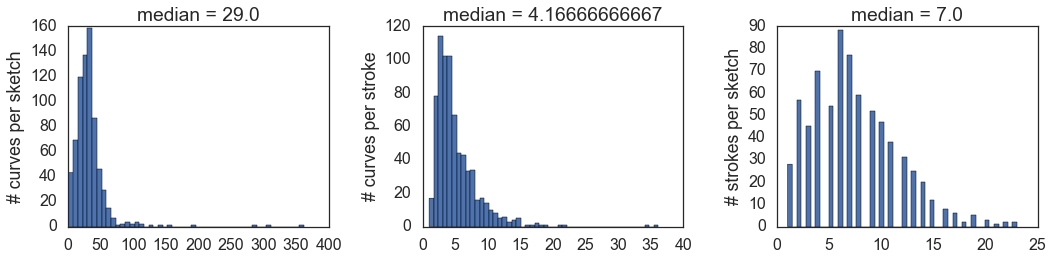

In [14]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
h = plt.hist(numCurvesPerSketch,50)
plt.title('median = ' + str(np.median(numCurvesPerSketch)))
plt.ylabel('# curves per sketch')
plt.subplot(1,3,2)
h = plt.hist(numCurvesPerStroke,50)
plt.title('median = ' + str(np.median(numCurvesPerStroke)))
plt.ylabel('# curves per stroke')
plt.subplot(1,3,3)
h = plt.hist(numStrokes,50)
plt.title('median = ' + str(np.median(numStrokes)))
plt.ylabel('# strokes per sketch')
plt.tight_layout()

In [15]:
# get summary statistics
far_strokes = []
close_strokes = []
far_svgLength = []
close_svgLength = []
far_svgStd = []
close_svgStd = []
far_svgLengthPS = []
close_svgLengthPS = []
far_drawDuration = []
close_drawDuration = []
far_accuracy = []
close_accuracy = []
for game in all_games:    
    far_strokes.append(D[(D['gameid']== game) & (D['condition'] == 'far')]['numStrokes'].mean())
    close_strokes.append(D[(D['gameid']== game) & (D['condition'] == 'close')]['numStrokes'].mean())
    far_svgLength.append(D[(D['gameid']== game) & (D['condition'] == 'far')]['svgStringLength'].mean())
    close_svgLength.append(D[(D['gameid']== game) & (D['condition'] == 'close')]['svgStringLength'].mean())
    far_svgStd.append(D[(D['gameid']== game) & (D['condition'] == 'far')]['svgStringStd'].mean())
    close_svgStd.append(D[(D['gameid']== game) & (D['condition'] == 'close')]['svgStringStd'].mean())    
    far_svgLengthPS.append(D[(D['gameid']== game) & (D['condition'] == 'far')]['svgStringLengthPerStroke'].mean())
    close_svgLengthPS.append(D[(D['gameid']== game) & (D['condition'] == 'close')]['svgStringLengthPerStroke'].mean())
    far_drawDuration.append(D[(D['gameid']== game) & (D['condition'] == 'far')]['drawDuration'].mean())
    close_drawDuration.append(D[(D['gameid']== game) & (D['condition'] == 'close')]['drawDuration'].mean())
    far_accuracy.append(D[(D['gameid']== game) & (D['condition'] == 'far')]['outcome'].mean())
    close_accuracy.append(D[(D['gameid']== game) & (D['condition'] == 'close')]['outcome'].mean())

In [16]:
print np.mean(far_strokes)
print np.mean(close_strokes)
print np.mean(far_svgLength)
print np.mean(close_svgLength)
print np.mean(far_svgStd)
print np.mean(close_svgStd)
print np.mean(far_svgLengthPS)
print np.mean(close_svgLengthPS)
print np.mean(far_drawDuration)
print np.mean(close_drawDuration)
print np.mean(far_accuracy)
print np.mean(close_accuracy)

6.89352766798
7.92526051024
112.008399209
121.235357528
12.6578157913
11.4601113103
18.6268801742
17.918311187
8.26902173913
9.53790873158
0.97628458498
0.916636722961


Saving figure to 'plots/svg_summary_scatter.pdf'... Done


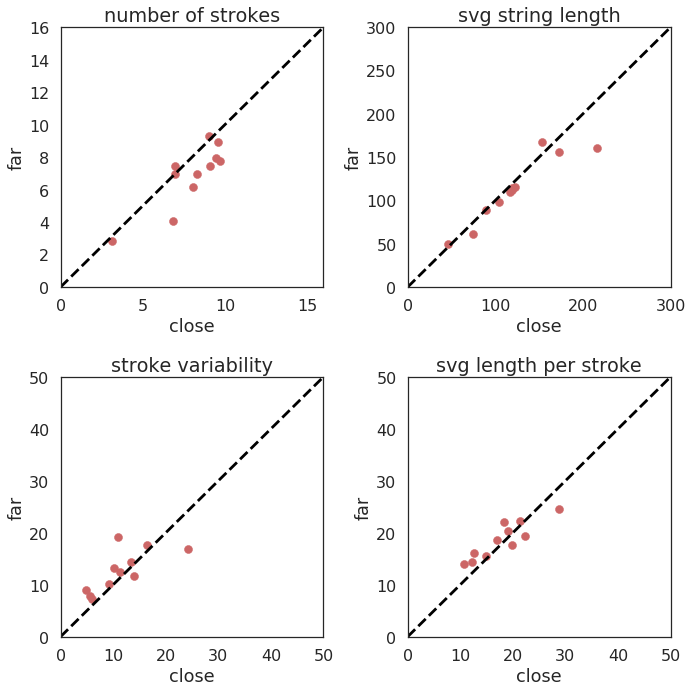

In [13]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(close_strokes,far_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('close')
plt.ylabel('far')
plt.subplot(2,2,2)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(close_svgLength,far_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('close')
plt.ylabel('far')
plt.subplot(2,2,3)
lb = 0
ub = 50
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(close_svgStd,far_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('close')
plt.ylabel('far')
plt.subplot(2,2,4)
lb = 0
ub = 50
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(close_svgLengthPS,far_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('close')
plt.ylabel('far')
save_out = 1
if save_out:
    helpers.save('plots/svg_summary_scatter', ext='pdf', close=False, verbose=True)

Saving figure to 'plots/performance_summary_scatter.pdf'... Done


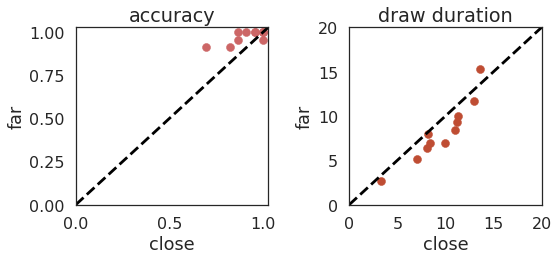

In [14]:
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(close_accuracy,far_accuracy,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('close')
plt.ylabel('far')
plt.subplot(1,2,2)
lb = 0
ub = 20
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(close_drawDuration,far_drawDuration,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration')
plt.xlabel('close')
plt.ylabel('far')
plt.tight_layout()
save_out = 1
if save_out:
    helpers.save('plots/performance_summary_scatter', ext='pdf', close=False, verbose=True)

Participants more affected by the close vs. far manipulation tend to produce sketches with more strokes, which are also more complex
0.236363636364 0.484091162225


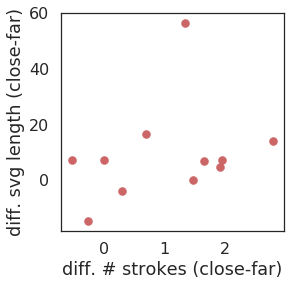

In [15]:
fig = plt.figure(figsize=(4,4))
plt.scatter(np.array(close_strokes)-np.array(far_strokes),np.array(close_svgLength)-np.array(far_svgLength),64,(0.8,0.4,0.4))
plt.xlabel('diff. # strokes (close-far)')
plt.ylabel('diff. svg length (close-far)')
r,p = stats.spearmanr(np.array(close_strokes)-np.array(far_strokes),np.array(close_svgLength)-np.array(far_svgLength))
print 'Participants more affected by the close vs. far manipulation tend to produce sketches with more strokes, which are also more complex'
print r,p

In [16]:
import numpy.random as npr
import pylab
def bootstrap(data, num_samples, statistic, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = npr.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [20]:
numStrokes = pd.DataFrame(np.vstack((close_strokes,far_strokes)).transpose(), \
                 columns = ['close','far'])
svgLength = pd.DataFrame(np.vstack((close_svgLength,far_svgLength)).transpose(), \
                 columns = ['close','far'])
strokeVariability = pd.DataFrame(np.vstack((close_svgStd,far_svgStd)).transpose(), \
                 columns = ['close','far'])
svgComplexity = pd.DataFrame(np.vstack((close_svgLengthPS,far_svgLengthPS)).transpose(), \
                 columns = ['close','far'])
accuracy = pd.DataFrame(np.vstack((close_accuracy,far_accuracy)).transpose(), \
                 columns = ['close','far'])
drawDuration = pd.DataFrame(np.vstack((close_drawDuration,far_drawDuration)).transpose(), \
                 columns = ['close','far'])

In [45]:
# compute within-subject error bars for visualization purposes
def get_within_subj_errbar(dataFrame):
    grand_mean = dataFrame.mean(1).mean(0)
    subj_mean = dataFrame.mean(1)
    new_x = dataFrame.ix[:,0] - subj_mean + grand_mean
    new_y = dataFrame.ix[:,1] - subj_mean + grand_mean
    normed = pd.DataFrame(np.vstack((new_x,new_y)).transpose(), columns = ['close', 'far'])
    sem = normed.std(0)/np.sqrt(len(normed))
    ci95 = sem * 1.96 
    return ci95

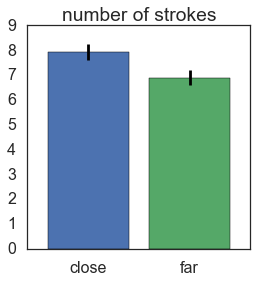

In [99]:
# plot within_subject error bars
eb = get_within_subj_errbar(numStrokes)
sns.set_style('white')
ind = np.arange(2)  # the x locations for the groups
width = 0.8       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind[0], numStrokes['close'].mean(), width, color=sns.color_palette()[0], yerr=eb['close'],ecolor='k')
rects2 = ax.bar(ind[1], numStrokes['far'].mean(), width, color=sns.color_palette()[1], yerr=eb['far'],ecolor='k')
ax.set_title('number of strokes')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('close', 'far'))
plt.xlim([-0.2,ind[1]+width+0.2])
fig.set_figheight(4)
fig.set_figwidth(4)


Saving figure to 'plots/svg_summary_bars.pdf'... Done


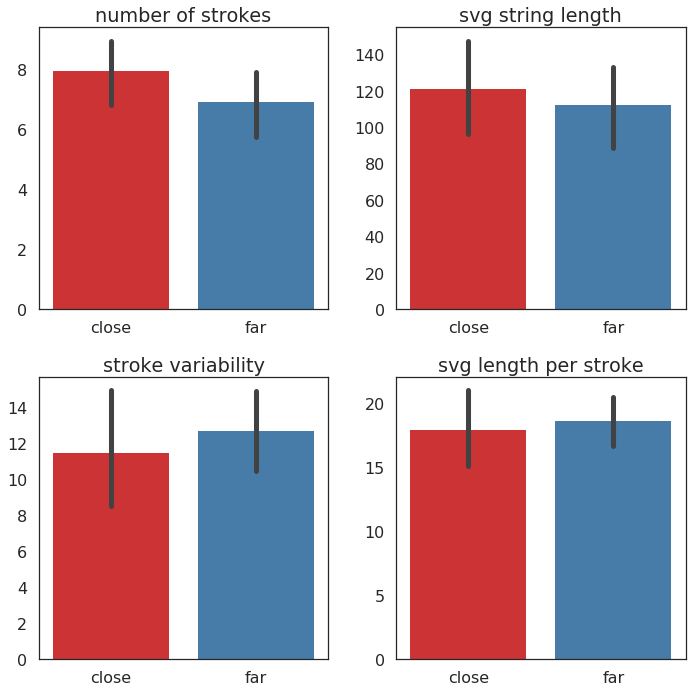

In [18]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.barplot(data=numStrokes,ci=95,palette="Set1")
plt.title('number of strokes')
plt.subplot(2,2,2)
sns.barplot(data=svgLength,ci=95,palette="Set1")
plt.tight_layout()
plt.title('svg string length')
plt.subplot(2,2,3)
sns.barplot(data=strokeVariability,ci=95,palette="Set1")
plt.tight_layout()
plt.title('stroke variability')
plt.subplot(2,2,4)
sns.barplot(data=svgComplexity,ci=95,palette="Set1")
plt.tight_layout()
plt.title('svg length per stroke')

save_out = 1
if save_out:
    helpers.save('plots/svg_summary_bars', ext='pdf', close=False, verbose=True)

Saving figure to 'plots/performance_summary_bars.pdf'... Done


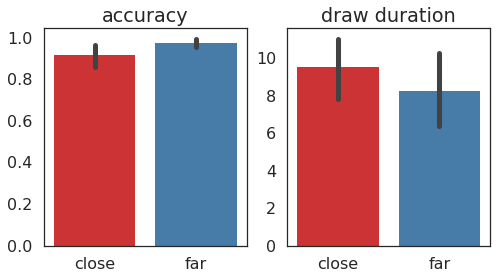

In [19]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.barplot(data=accuracy,ci=95,palette="Set1")
plt.title('accuracy')
plt.subplot(1,2,2)
sns.barplot(data=drawDuration,ci=95,palette="Set1")
plt.title('draw duration')
save_out = 1
if save_out:
    helpers.save('plots/performance_summary_bars', ext='pdf', close=False, verbose=True)